## Estimating PI

In [1]:
from src.dataset import create_multiple_circles
from src.torch_ripsnet import DenseNestedTensors, PermopNestedTensors


import gudhi as gd
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from gudhi.representations import DiagramSelector
from gudhi.representations import Landscape, PersistenceImage

## Dataset

In [2]:
N_sets_train = 900  # Number of train point clouds
N_sets_test = 300  # Number of test  point clouds
N_points = 600  # Point cloud cardinality
N_noise = 200  # Number of corrupted points

In [3]:
data_train, label_train = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
clean_data_test, clean_label_test = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
noisy_data_test, noisy_label_test = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|██████████| 100/100 [00:00<00:00, 132.08it/s]


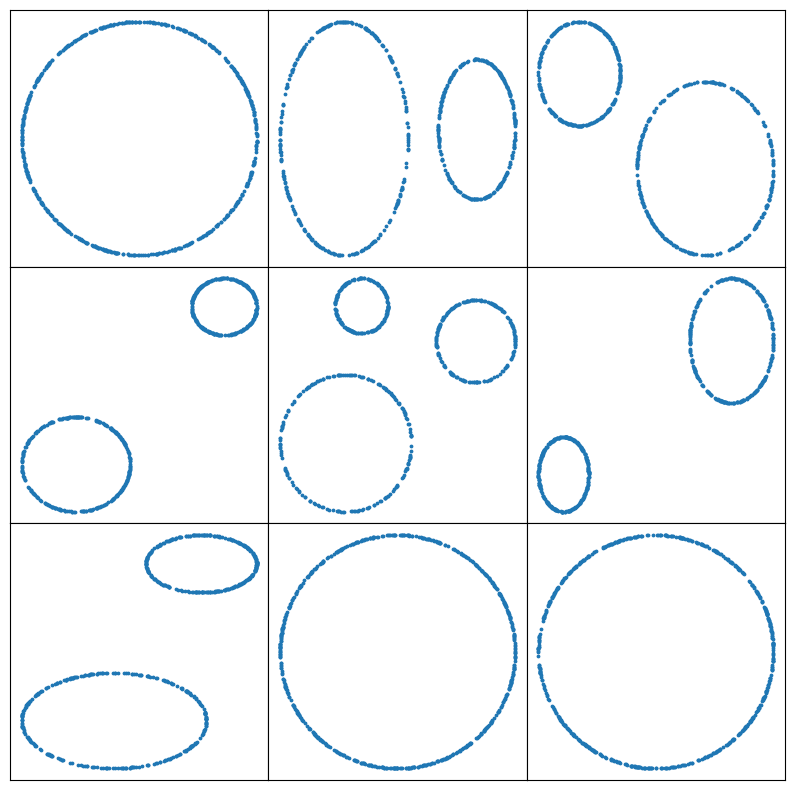

In [4]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(clean_data_test[3*i+j][:,0], clean_data_test[3*i+j][:,1], s=3)
        plt.xticks([])
        plt.yticks([])
plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

In [5]:
le = LabelEncoder().fit(label_train)
label_classif_train = le.transform(label_train)
clean_label_classif_test  = le.transform(clean_label_test)
noisy_label_classif_test  = le.transform(noisy_label_test)

In [6]:
ds = [pairwise_distances(X).flatten() for X in data_train[:30]]
maxd = np.max(np.concatenate(ds))

In [7]:
# train PD
PD_train = []
for X in tqdm(data_train):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    PD_train.append(dg)

# test PD
clean_PD_test = []
for X in tqdm(clean_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    clean_PD_test.append(dg)


# noisy PD
noisy_PD_test = []
for X in tqdm(noisy_data_test):
    st = gd.AlphaComplex(points=X).create_simplex_tree(max_alpha_square=maxd)
    st.persistence()
    dg = st.persistence_intervals_in_dimension(1)
    if len(dg) == 0:
        dg = np.empty([0,2])
    noisy_PD_test.append(dg)

100%|██████████| 300/300 [00:02<00:00, 126.60it/s]


In [9]:
PVs_train, clean_PVs_test, noisy_PVs_test, PVs_params = [], [], [], []
pds_train = DiagramSelector(use=True).fit_transform(PD_train)
clean_pds_test = DiagramSelector(use=True).fit_transform(clean_PD_test)
noisy_pds_test = DiagramSelector(use=True).fit_transform(noisy_PD_test)

TP_train = [(pd[:,1] - pd[:,0]).sum() for pd in pds_train]
TP_clean_test = [(pd[:,1] - pd[:,0]).sum() for pd in clean_pds_test]
TP_noisy_test = [(pd[:,1] - pd[:,0]).sum() for pd in noisy_pds_test]

In [10]:
vpdtr = np.vstack(pds_train)
pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2)
im_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,0],1.), np.quantile(pers,0.), np.quantile(pers,1.)]
sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]

In [11]:
### Persistence Images
PI_params = {'bandwidth': sigma, 
             'weight': lambda x: 10*np.tanh(x[1]), 
             'resolution': [50,50], 
             'im_range': im_bnds
             }
PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
noisy_PI_test = PersistenceImage(**PI_params).fit_transform(noisy_pds_test)
MPI = np.max(PI_train)
PI_train /= MPI
clean_PI_test /= MPI
noisy_PI_test /= MPI

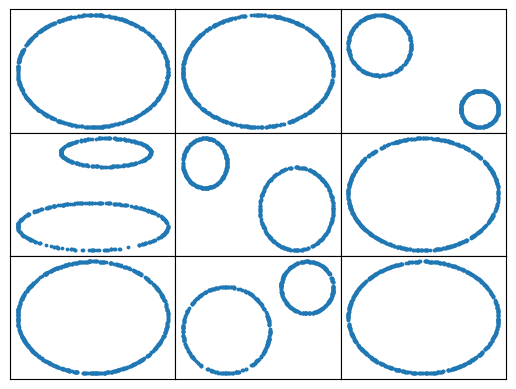

In [15]:
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
data_train_np = np.asarray(data_train)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(data_train_np[3*i+j,:,0], data_train_np[3*i+j,:,1], s=3)
        plt.xticks([])
        plt.yticks([])

/home/jmordacq/miniconda3/envs/toplayer/lib/python3.9/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


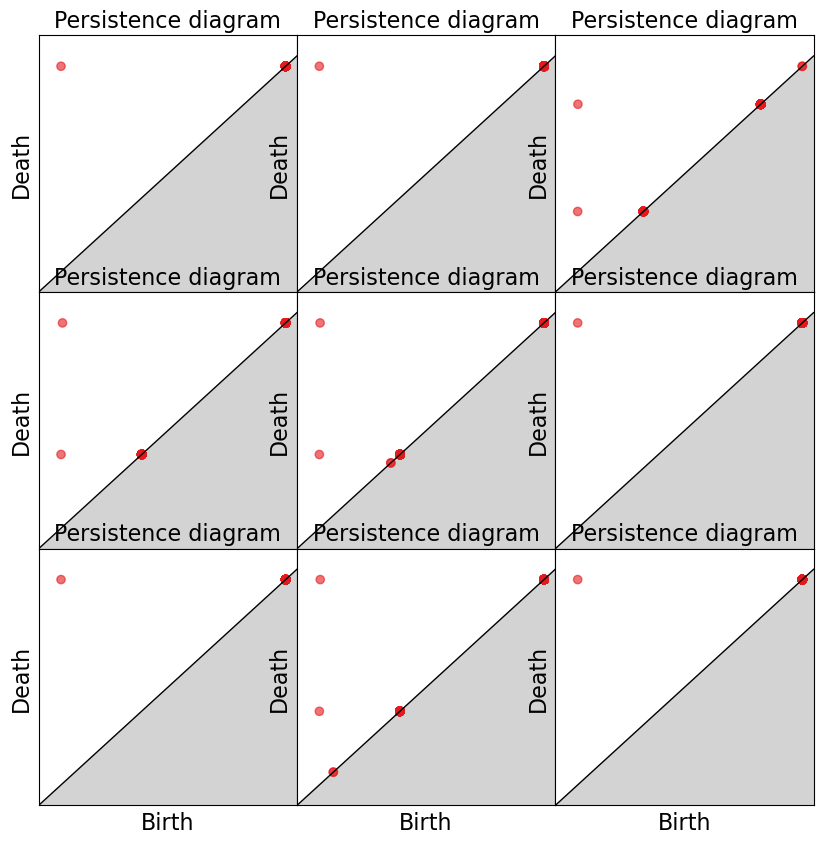

In [17]:

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        gd.plot_persistence_diagram(PD_train[3*i+j], axes=ax)
        plt.xticks([])
        plt.yticks([])

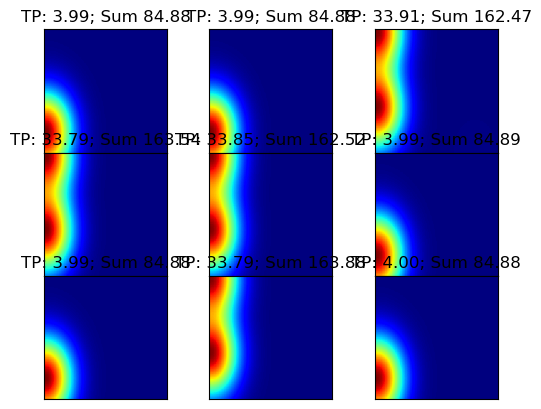

In [27]:

gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        summing = float(np.sum(PI_train[3*i+j]))
        ax.imshow(np.flip(np.reshape(PI_train[3*i+j], [50,50]), 0), cmap='jet')
        ax.set_title('TP: {:.2f}; Sum {:.2f}'.format(TP_train[3*i+j], 
                                              summing))
        plt.xticks([])
        plt.yticks([])

In [85]:
def estimate_tp(pi, im_bnds, weight=lambda x: 10 * np.tanh(x)):
    resolution = pi.shape
    ### compute the x and y coordinates ###
    # ys
    step_y = (im_bnds[3]-im_bnds[2]) / (resolution[1]) # sample the middle of the cell
    y = [im_bnds[2] + (i * step_y) + (step_y / 2) for i in range(resolution[1])]
    # xs
    step_x = (im_bnds[1]-im_bnds[0]) / (resolution[0])
    x = [im_bnds[0] + (i * step_x) + (step_x / 2) for i in range(resolution[0])]

    print(y)
    point_wise = [ (y[i] * pi[j][i] ) / weight(y[i]) for i in range(resolution[1]) for j in range(resolution[0])]
    # point_wise_x = [ (x[j] * pi[j][i]) / weight(y[i]) for i in range(resolution[1]) for j in range(resolution[0])]

    return np.sum(point_wise)  

In [86]:
estimate_tp(np.reshape(PI_train[0], (50,50)), im_bnds)

[0.2495218277742168, 0.7485654833226495, 1.2476091388710822, 1.746652794419515, 2.2456964499679475, 2.7447401055163803, 3.243783761064813, 3.742827416613246, 4.241871072161678, 4.74091472771011, 5.239958383258544, 5.739002038806976, 6.238045694355409, 6.737089349903841, 7.236133005452275, 7.735176661000707, 8.234220316549141, 8.733263972097573, 9.232307627646005, 9.731351283194439, 10.23039493874287, 10.729438594291304, 11.228482249839736, 11.72752590538817, 12.226569560936602, 12.725613216485035, 13.224656872033467, 13.7237005275819, 14.222744183130333, 14.721787838678766, 15.220831494227198, 15.719875149775632, 16.218918805324062, 16.717962460872496, 17.21700611642093, 17.716049771969363, 18.215093427517793, 18.714137083066227, 19.21318073861466, 19.712224394163094, 20.211268049711524, 20.710311705259958, 21.20935536080839, 21.708399016356825, 22.207442671905255, 22.70648632745369, 23.205529983002123, 23.704573638550556, 24.203617294098986, 24.70266094964742]


27.036652169951388